In [ ]:
import numpy as np, pandas as pd, torch, torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import precision_score, recall_score


In [ ]:
SEQ_LEN      = 8
EPOCHS       = 100
BATCH_TRAIN  = 64
BATCH_VAL    = 128
RATIO_GRID   = [0.05,0.1,0.25,0.50,1.00]
SEED         = 42
LR           = 1e-3
PATIENCE       = 20
MIN_DELTA      = 1e-3
THRESHOLDS     = np.arange(0.1, 1.0, 0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED); np.random.seed(SEED)

In [ ]:
print(device)

cuda


In [ ]:

df = pd.read_csv("ibtracscyclicfinal.csv")
df = pd.get_dummies(df, columns=["basin"], drop_first=False)
df = df.sort_values(["storm_id", "lead"])
df = df.drop_duplicates(subset=["storm_id", "lead"]).reset_index(drop=True)

storms = (df[["storm_id", "istc"]]
          .drop_duplicates()
          .reset_index(drop=True))

num_cols = ["wind","slp","pr","rh","rv","geop"]
frame_cols = (
    num_cols +
    ["sin_hour","cos_hour","sin_doy","cos_doy",
     "sin_lon","cos_lon","lat_norm",
     "lead"] +
    [c for c in df.columns if c.startswith("basin_")]   # ← add 7 basin dummies
)

In [ ]:
def build_xy(frame_df, seq_len=SEQ_LEN):
    xs, ys = [], []
    dbase  = len(frame_cols)

    for _, g in frame_df.groupby("storm_id", sort=False):
        g = g.sort_values("lead").tail(seq_len)
        arr = g[frame_cols].to_numpy(np.float32)

        if arr.shape[0] < seq_len:
            pad = np.zeros((seq_len - arr.shape[0], dbase), np.float32)
            arr = np.concatenate((pad, arr), axis=0)

        xs.append(arr.reshape(-1))
        ys.append(float(g["istc"].iloc[-1]))

    xs = np.asarray(xs, np.float32)
    ys = np.asarray(ys, np.float32)
    assert xs.shape[0] == ys.shape[0], "build_xy produced ragged output"
    return xs, ys


In [ ]:

train_ids, temp_ids, y_train_g, y_temp_g = train_test_split(
        storms["storm_id"], storms["istc"],
        test_size=0.30, stratify=storms["istc"],
        random_state=SEED)

val_ids,  test_ids, y_val_g, y_test_g = train_test_split(
        temp_ids, y_temp_g,
        test_size=0.50, stratify=y_temp_g,
        random_state=SEED)

train_df = df[df["storm_id"].isin(train_ids)].reset_index(drop=True)
val_df   = df[df["storm_id"].isin(val_ids )].reset_index(drop=True)
test_df  = df[df["storm_id"].isin(test_ids)].reset_index(drop=True)

X_train, y_train = build_xy(train_df)
X_val,   y_val   = build_xy(val_df)
X_test,  y_test  = build_xy(test_df)
print("train shapes:", X_train.shape, y_train.shape)

scaler  = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val   = scaler.transform(X_val)


train shapes: (11193, 168) (11193,)


In [ ]:
class MLP(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.net(x)

In [ ]:
def eval_fixed(model, loader, thr_list,criterion):
    model.eval(); y_t, y_p, run = [], [], 0.
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb).squeeze()
            run += criterion(logits, yb).item()
            y_p.append(torch.sigmoid(logits).cpu().numpy())
            y_t.append(yb.cpu().numpy())
    y_t = np.concatenate(y_t);  y_p = np.concatenate(y_p)
    out = []
    for t in thr_list:
        out.append({
            'threshold': t,
            'f1': f1_score(y_t, (y_p >= t).astype(int), zero_division=0),
            'pr': average_precision_score(y_t, y_p)
        })
    return run / len(loader), out

In [ ]:
results = []
FINAL_RATIO = 1.0

print("SMOTE input rows:", X_train.shape[0], len(y_train))
print(FINAL_RATIO)
assert X_train.shape[0] == len(y_train), "length mismatch just before SMOTE"
smote = SMOTE(sampling_strategy=max(FINAL_RATIO, 0.01),
              k_neighbors=3, random_state=SEED)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

m, M = (y_sm == 1).sum(), (y_sm == 0).sum()
if m / M < FINAL_RATIO:
    M_target = int(m / FINAL_RATIO)
    rus = RandomUnderSampler(sampling_strategy=m/M_target,
                              random_state=SEED)
    X_bal, y_bal = rus.fit_resample(X_sm, y_sm)
else:
    X_bal, y_bal = X_sm, y_sm

print(f"[ratio {FINAL_RATIO:.3f}] class dist "
      f"{np.bincount(y_bal.astype(int))}")

tr_loader = DataLoader(TensorDataset(
                torch.tensor(X_train), torch.tensor(y_train)),
                batch_size=BATCH_TRAIN, shuffle=True)
vl_loader = DataLoader(TensorDataset(
                torch.tensor(X_val), torch.tensor(y_val)),
                batch_size=BATCH_VAL, shuffle=False)

model = MLP(X_train.shape[1]).to(device)
opt     = torch.optim.Adam(model.parameters(), lr=LR,
                            weight_decay=1e-3)
total = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total)
pos_weight = torch.tensor([(y_train==0).sum()/(y_train==1).sum()],
                      dtype=torch.float32, device=device)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(EPOCHS):
    model.train()
    for xb, yb in tr_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = criterion(model(xb).squeeze(), yb)
        loss.backward(); opt.step()

def _eval(loader):
    model.eval(); y_t, y_p = [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb.to(device)).squeeze()
            y_p.append(torch.sigmoid(logits).cpu().numpy())
            y_t.append(yb.numpy())
    return np.concatenate(y_t), np.concatenate(y_p)

_y_train, p_train = _eval(tr_loader)
_y_val,   p_val   = _eval(vl_loader)

def metrics_table(y, p):
  tbl, best_f1, best_thr = [], -1, 0
  for t in THRESHOLDS:
    y_hat = (p >= t).astype(int)
    prc   = precision_score(y, y_hat, zero_division=0)
    rec   = recall_score   (y, y_hat, zero_division=0)
    f1    = f1_score       (y, y_hat, zero_division=0)
    pr_auc= average_precision_score(y, p)
    tbl.append({
        'threshold': t,
        'precision': prc,
        'recall'   : rec,
        'f1'       : f1,
        'pr_auc'   : pr_auc
    })
    if f1 > best_f1:
      best_f1, best_thr = f1, t
      best_prec, best_rec = prc, rec
    return tbl, best_f1, best_thr, best_prec, best_rec


tr_metrics, tr_best_f1, tr_thr, tr_prec, tr_rec = metrics_table(_y_train, p_train)
vl_metrics, vl_best_f1, vl_thr, vl_prec, vl_rec = metrics_table(_y_val,   p_val)

results.append({
    'train_metrics': tr_metrics,
    'val_metrics'  : vl_metrics,
    'train_best_f1': tr_best_f1,
    'train_best_prec': tr_prec,
    'train_best_rec' : tr_rec,
    'val_best_f1'  : vl_best_f1,
    'val_best_prec': vl_prec,
    'val_best_rec' : vl_rec,
    'val_best_thr' : vl_thr
})


SMOTE input rows: 11193 11193
1.0
[ratio 1.000] class dist [11085 11085]
13121


In [ ]:
print("\n=========== MLP sweep result ===========")
for r in results:
  print(f"| best train-F1 {r['train_best_f1']:.3f}  "
          f"(P {r['train_best_prec']:.3f}, R {r['train_best_rec']:.3f})  |  "
          f"best val-F1 {r['val_best_f1']:.3f}  "
          f"(P {r['val_best_prec']:.3f}, R {r['val_best_rec']:.3f})  "
          f"@thr {r['val_best_thr']:.2f}\n")

  print("  Training metrics:")
  for m in r['train_metrics']:
      print(f"    thr {m['threshold']:.1f}  F1 {m['f1']:.3f}  PR {m['pr_auc']:.3f}")

  print("  Validation metrics:")
  for m in r['val_metrics']:
      print(f"    thr {m['threshold']:.1f}  F1 {m['f1']:.3f}  PR {m['pr_auc']:.3f}")




=========== MLP sweep result ===========
| best train-F1 0.631  (P 0.566, R 0.713)  |  best val-F1 0.400  (P 0.429, R 0.375)  @thr 0.10

  Training metrics:
    thr 0.1  F1 0.631  PR 0.716
  Validation metrics:
    thr 0.1  F1 0.400  PR 0.414


In [ ]:
!pip install lime


--- Starting LIME Analysis for the trained MLP Model ---
Found instance for False Negative: Yes
Found instance for False Positive: Yes
Found instance for True Negative:  Yes
Found instance for True Positive:  Yes

--- Explaining: True Positive (Validation Set Index: 55) ---
True Label: Tropical Cyclone
Model Prediction Probs -> Not TC: 0.2756, Is TC: 0.7244


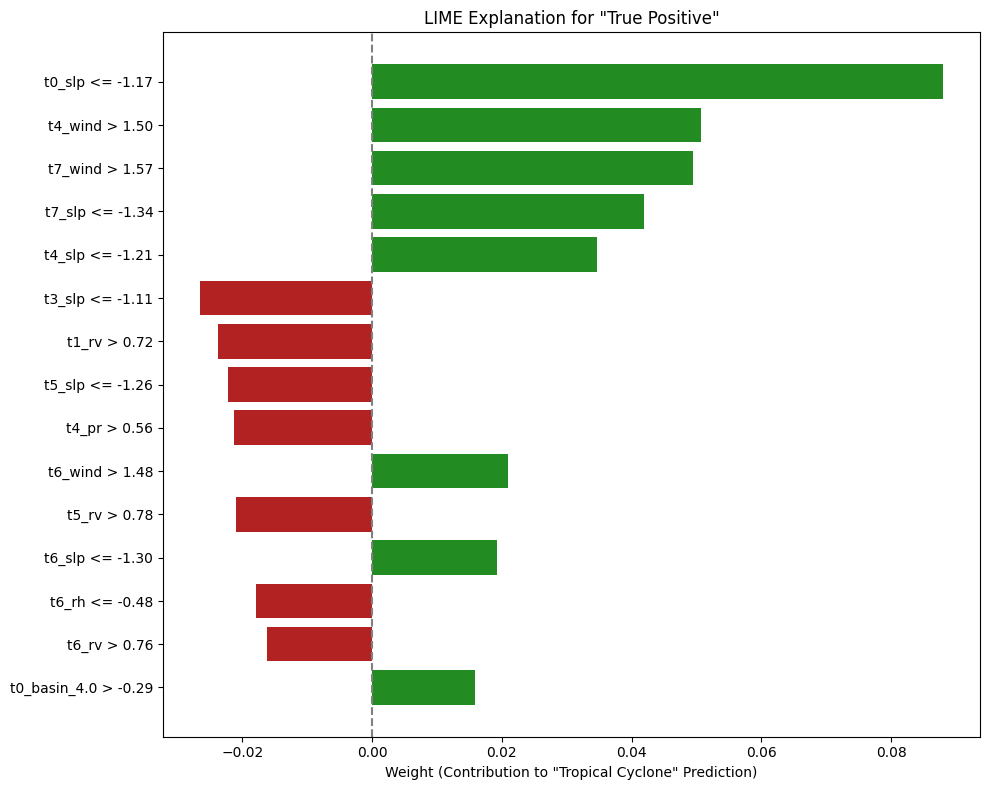


--- Explaining: True Negative (Validation Set Index: 0) ---
True Label: Not Tropical Cyclone
Model Prediction Probs -> Not TC: 0.9893, Is TC: 0.0107


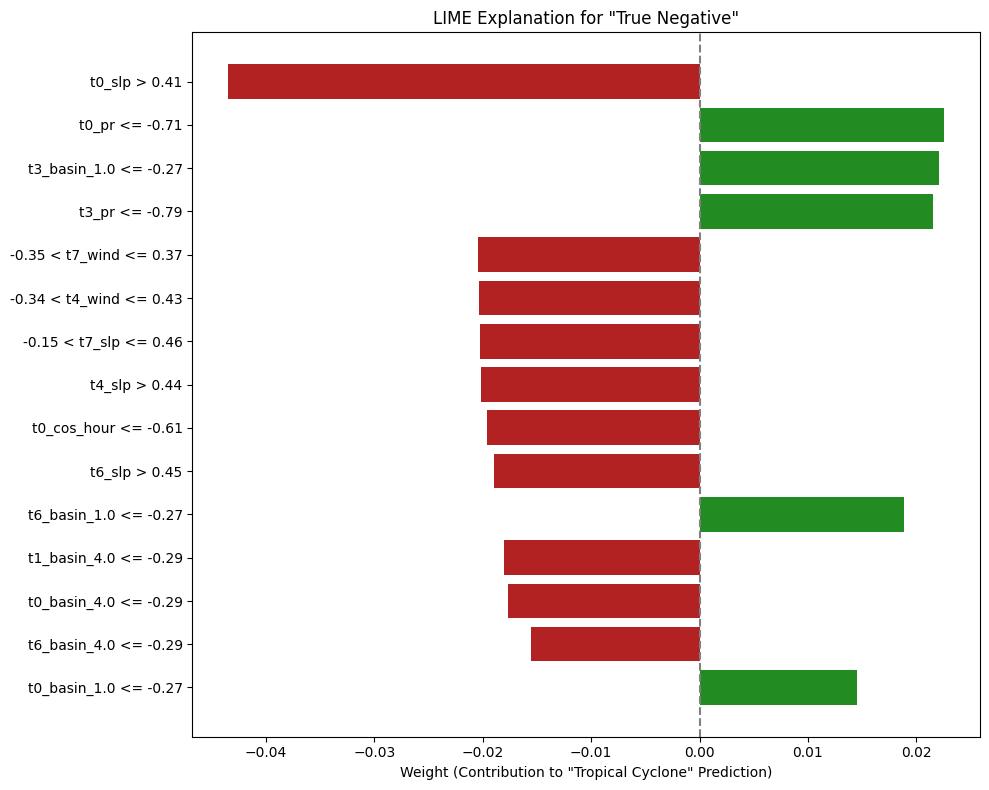


--- Explaining: False Positive (Validation Set Index: 130) ---
True Label: Not Tropical Cyclone
Model Prediction Probs -> Not TC: 0.8331, Is TC: 0.1669


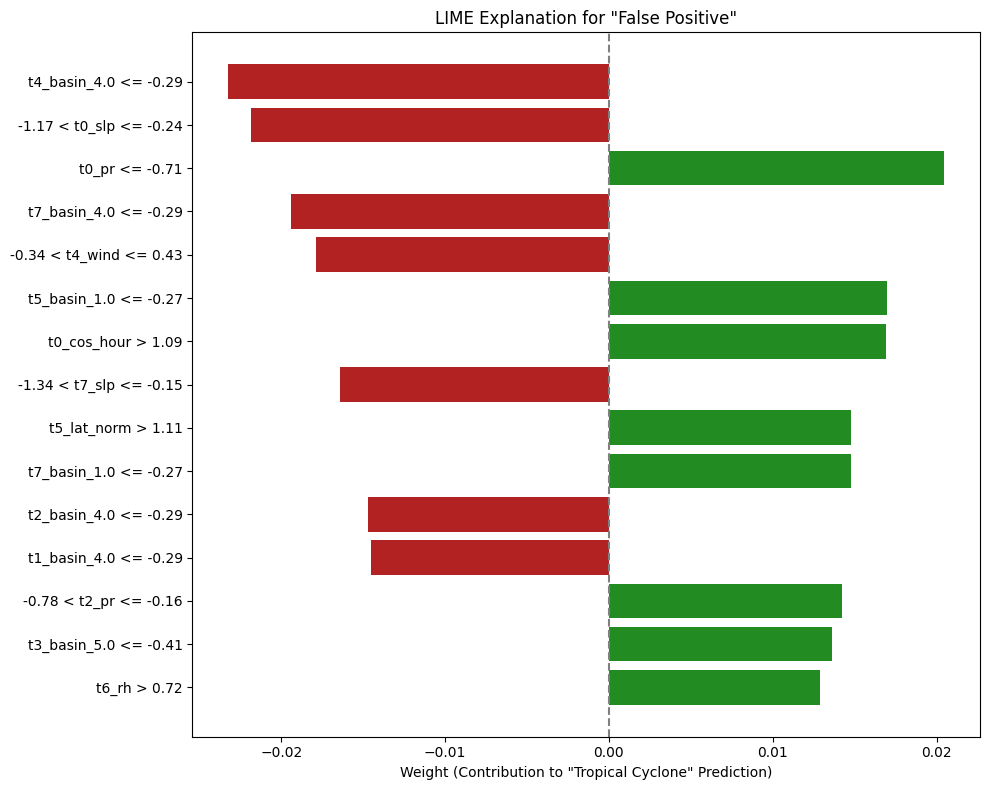


--- Explaining: False Negative (Validation Set Index: 52) ---
True Label: Tropical Cyclone
Model Prediction Probs -> Not TC: 0.9161, Is TC: 0.0839


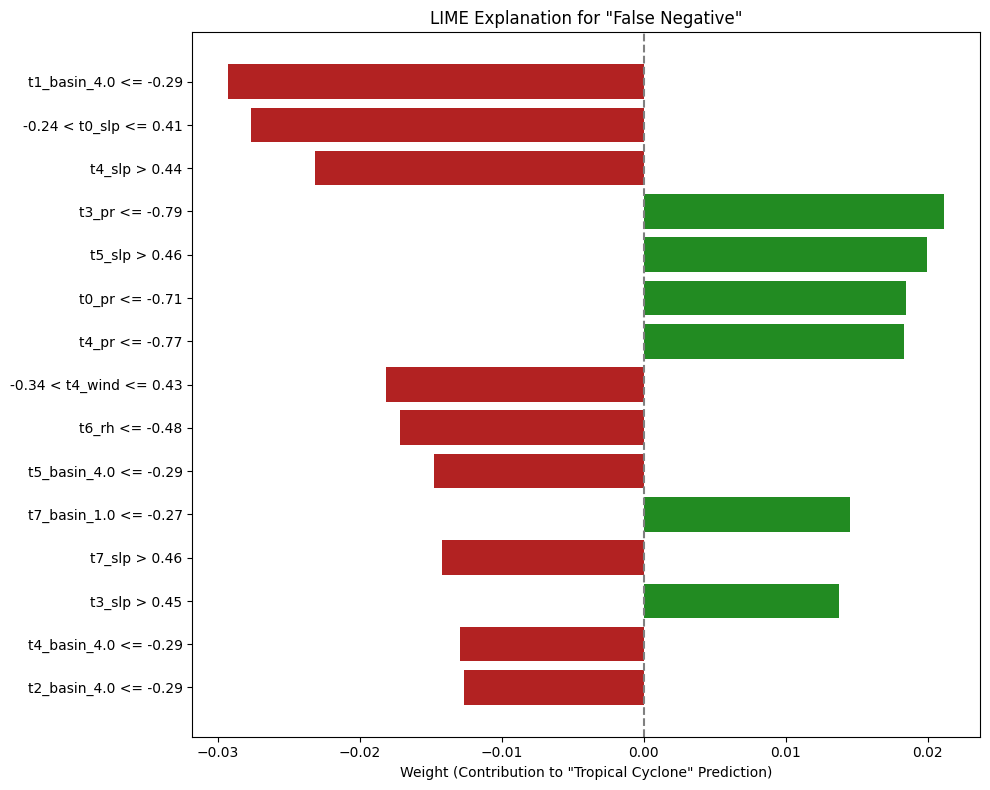

--- LIME Analysis for MLP Model Complete ---



In [ ]:
#
import lime
import lime.lime_tabular
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(f"\n--- Starting LIME Analysis for the trained MLP Model ---")

model.eval()
y_val_pred_proba = []
with torch.no_grad():
    for xb, yb in vl_loader:
        logits = model(xb.to(device)).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
        y_val_pred_proba.append(probs)
y_val_pred_proba = np.concatenate(y_val_pred_proba)

PREDICTION_THRESHOLD = vl_thr
y_val_pred_class = (y_val_pred_proba >= PREDICTION_THRESHOLD).astype(int)
y_val_true = y_val

false_neg_idx = np.where((y_val_true == 1) & (y_val_pred_class == 0))[0]
false_pos_idx = np.where((y_val_true == 0) & (y_val_pred_class == 1))[0]
true_neg_idx  = np.where((y_val_true == 0) & (y_val_pred_class == 0))[0]
true_pos_idx  = np.where((y_val_true == 1) & (y_val_pred_class == 1))[0]

fn_idx = false_neg_idx[0] if len(false_neg_idx) > 0 else None
fp_idx = false_pos_idx[0] if len(false_pos_idx) > 0 else None
tn_idx = true_neg_idx[0] if len(true_neg_idx) > 0 else None
tp_idx = true_pos_idx[0] if len(true_pos_idx) > 0 else None

print(f"Found instance for False Negative: {'Yes' if fn_idx is not None else 'No'}")
print(f"Found instance for False Positive: {'Yes' if fp_idx is not None else 'No'}")
print(f"Found instance for True Negative:  {'Yes' if tn_idx is not None else 'No'}")
print(f"Found instance for True Positive:  {'Yes' if tp_idx is not None else 'No'}")



def lime_predict_fn(numpy_array_2d):
    model.eval()
    with torch.no_grad():
        tensor_input = torch.from_numpy(numpy_array_2d).float().to(device)
        logits = model(tensor_input)
        probabilities = torch.sigmoid(logits).cpu().numpy()
        return np.hstack((1 - probabilities, probabilities))

feature_names = [f"t{i//len(frame_cols)}_{frame_cols[i%len(frame_cols)]}" for i in range(X_train.shape[1])]

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_bal,
    feature_names=feature_names,
    class_names=['Not Tropical Cyclone', 'Tropical Cyclone'],
    mode='classification'
)

def explain_instance_with_plot(title, instance_idx):
    if instance_idx is None:
        print(f"\n--- {title}: No instance found to explain. ---")
        return

    print(f"\n--- Explaining: {title} (Validation Set Index: {instance_idx}) ---")

    instance_to_explain = X_val[instance_idx]

    pred_probs = lime_predict_fn(instance_to_explain.reshape(1, -1))[0]
    true_label_text = 'Tropical Cyclone' if y_val_true[instance_idx] == 1 else 'Not Tropical Cyclone'

    print(f"True Label: {true_label_text}")
    print(f"Model Prediction Probs -> Not TC: {pred_probs[0]:.4f}, Is TC: {pred_probs[1]:.4f}")

    explanation = explainer.explain_instance(
        instance_to_explain,
        lime_predict_fn,
        num_features=15,
        labels=(1,)
    )

    exp_list = explanation.as_list(label=1)
    exp_list.reverse()

    fig, ax = plt.subplots(figsize=(10, 8))

    feature_conditions = [x[0] for x in exp_list]
    feature_weights = [x[1] for x in exp_list]

    colors = ['forestgreen' if w > 0 else 'firebrick' for w in feature_weights]

    positions = np.arange(len(exp_list))
    ax.barh(positions, feature_weights, align='center', color=colors)

    ax.set_yticks(positions)
    ax.set_yticklabels(feature_conditions)
    ax.set_title(f'LIME Explanation for "{title}"')
    ax.set_xlabel('Weight (Contribution to "Tropical Cyclone" Prediction)')
    ax.axvline(x=0, color='grey', linestyle='--')

    fig.tight_layout()
    plt.show()

explain_instance_with_plot("True Positive", tp_idx)
explain_instance_with_plot("True Negative", tn_idx)
explain_instance_with_plot("False Positive", fp_idx)
explain_instance_with_plot("False Negative", fn_idx)

print(f"--- LIME Analysis for MLP Model Complete ---\n")



Calculating SHAP values...
SHAP values calculated.
Original SHAP values shape: (1000, 168, 1)
Reshaped SHAP values to: (1000, 168)

SHAP Summary Plot (Global Feature Importance):


<ipython-input-11-456c36524a2b>:46: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, instances_df, plot_type="bar", show=False)


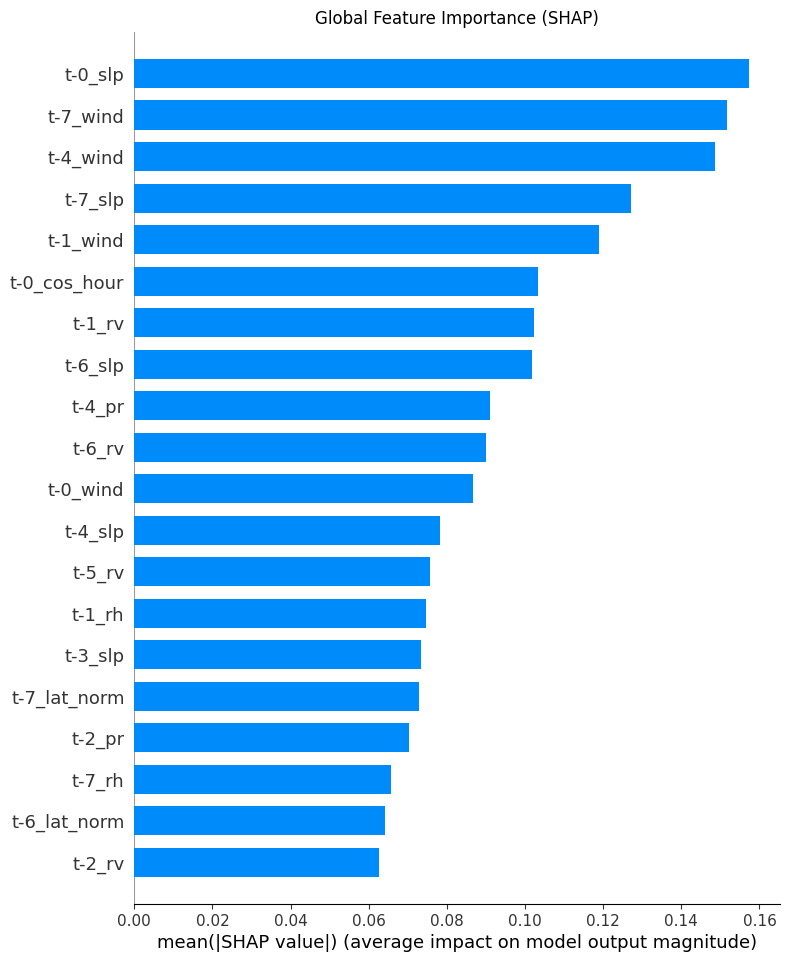


SHAP Feature Impact Summary Plot:


<ipython-input-11-456c36524a2b>:52: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, instances_df, show=False)


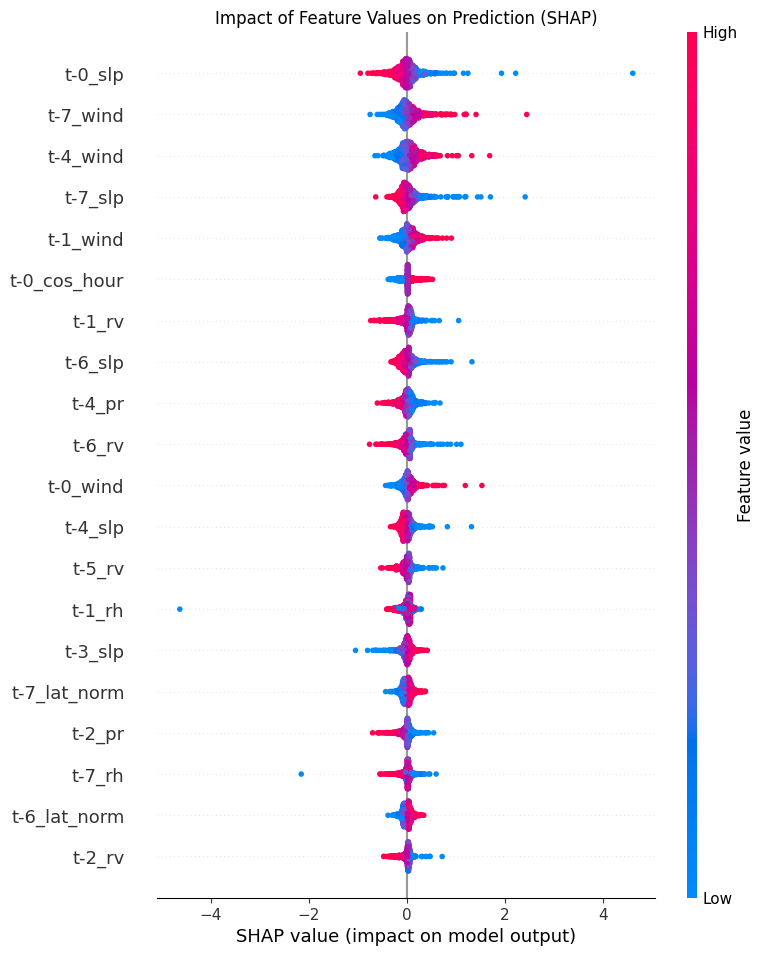


SHAP Force Plot for the first validation instance:



SHAP Force Plot for the second validation instance (Matplotlib):


<Figure size 640x480 with 0 Axes>

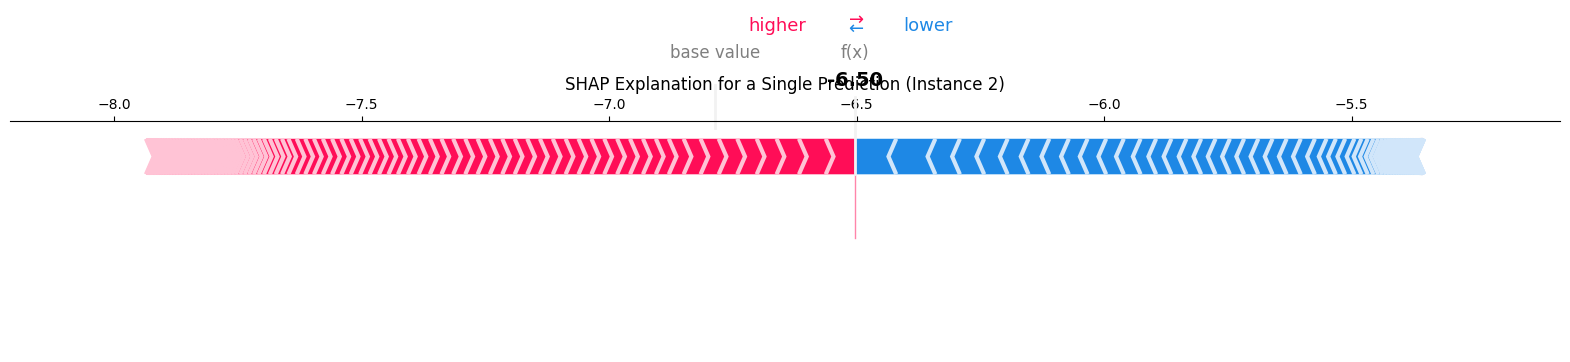

In [ ]:
import shap
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



background = torch.tensor(X_train[np.random.choice(X_train.shape[0], 100, replace=False)], dtype=torch.float32).to(device)

instances_to_explain = torch.tensor(X_val[:1000], dtype=torch.float32).to(device)

explainer = shap.DeepExplainer(model, background)

print("\nCalculating SHAP values...")
shap_values_raw = explainer.shap_values(instances_to_explain)
print("SHAP values calculated.")


feature_names = [f"t-{i//len(frame_cols)}_{frame_cols[i%len(frame_cols)]}" for i in range(X_train.shape[1])]

instances_np = instances_to_explain.cpu().numpy()
instances_df = pd.DataFrame(instances_np, columns=feature_names)

print(f"Original SHAP values shape: {shap_values_raw.shape}")
if len(shap_values_raw.shape) == 3:
    shap_values = shap_values_raw[:, :, 0]
    print(f"Reshaped SHAP values to: {shap_values.shape}")
else:
    shap_values = shap_values_raw

print("\nSHAP Summary Plot (Global Feature Importance):")
shap.summary_plot(shap_values, instances_df, plot_type="bar", show=False)
plt.title("Global Feature Importance (SHAP)")
plt.show()

print("\nSHAP Feature Impact Summary Plot:")
shap.summary_plot(shap_values, instances_df, show=False)
plt.title("Impact of Feature Values on Prediction (SHAP)")
plt.show()


=
print(f"\nSHAP Force Plot for the first validation instance:")
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0],
    shap_values=shap_values[0,:],
    features=instances_df.iloc[0:1,:]
)

print(f"\nSHAP Force Plot for the second validation instance (Matplotlib):")

=plt.figure()
shap.force_plot(
    base_value=explainer.expected_value[0],
    shap_values=shap_values[1,:],
    features=instances_df.iloc[1,:],
    matplotlib=True,
    show=False
)
plt.title("SHAP Explanation for a Single Prediction (Instance 2)")
plt.show()
